The purpose of this project is to implement formulas for the Greeks and then use them to test various methods of doing Monte Carlo Greeks. 
The functions written in the first section will be used in later projects.

Import necessary libraries

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from random import random
from random import randint

## Required classes

We include the class Option from project $1$ so that Greeks class can inherit from it.

In [2]:
class PayOff:
    def __init__(self, TheOptionsType_, Strike_):
        '''
        Inputs:
        =========
        TheOptionsType_: string (European call, European put, Binary call, Binary put)
        Strike_: float strike price
        '''
        
        self.__TheOptionsType = TheOptionsType_
        self.__Strike = Strike_
        
    def __call__(self,spot):
        # Overloading the ( ) operator
        '''
        inputs:
        =========
        spot: numpy array of spot prices
        
        
        returns:
        =========
        payoff value for each option 
        '''
        
        if self.__TheOptionsType == 'European call':
            return np.maximum(spot - self.__Strike,0)
        elif self.__TheOptionsType == 'European put':
            return np.maximum(self.__Strike - spot,0)
        elif self.__TheOptionsType == 'Binary call':
            return np.piecewise(spot, [spot < self.__Strike, spot >= self.__Strike], [0, 1])
        elif self.__TheOptionsType == 'Binary put':
            return np.piecewise(spot, [spot <= self.__Strike, spot > self.__Strike], [1, 0])
        else:
            raise Exception('Unknown option type found.')

In [3]:
class Option:
    def __init__(self, S, K, r, d, sigma, T):
        '''
        Parameters:
        ===========
        S: stock price 
        K: strike price
        r: risk-free interest rate
        d: dividend 
        sigma: volatility (implied)
        T: time to maturity
        
        
        Returns: 
        ===========
        Forward price, vanilla European call and put option' prices, cash-or-nothing call and put options' prices,
        zero coupon bond and forward contract.
        '''
        
        self.S = S
        self.K = K
        self.r = r
        self.d = d
        self.sigma = sigma
        self.T = T
        
        self.d1 = (np.log(self.S/self.K) + (self.r - self.d + self.sigma**2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
        self.d2 = self.d1 - self.sigma * np.sqrt(self.T)
    
    def forward_price(self):
        '''
        output forward price
        '''        
        return self.S * np.exp(self.r * self.T)
    
    def european_call(self):
        '''
        output vanilla European call option's price using Black-Scholes formula 
        '''        
        return self.S * np.exp(-self.d * self.T) * norm.cdf(self.d1) - self.K * np.exp(-self.r * self.T)*norm.cdf(self.d2)
    
    def european_put(self):
        '''
        output vanilla European put option's price using Black-Scholes formula 
        '''        
        return self.K * np.exp(-self.r * self.T)*norm.cdf(-self.d2) - self.S * np.exp(-self.d * self.T)*norm.cdf(-self.d1)
    
    def binary_call(self, face_value):
        '''
        output cash-or-nothing call option's price
        '''
        return face_value * np.exp(-self.r * self.T) * norm.cdf(self.d2)

    def binary_put(self, face_value):
        '''
        ouput cash-or-nothing put option's price
        '''
        return face_value * np.exp(-self.r * self.T) * norm.cdf(-self.d2)
    
    def zero_coupon_bond(self, face_value):
        '''
        output zero coupon bond's price based on the face value
        '''
        return face_value * np.exp(-self.r * self.T)
    
    def forward_contract(self):
        '''
        output forward contract's value
        '''
        return self.S * np.exp(-self.d * self.T) - self.K * np.exp(-self.r * self.T)
    
    def print_all_values(self, face_value):
        '''
        print prices of all options and zero coupon bond
        '''
        print('Forward price: {}'.format(self.forward_price()))
        print('European call: {}'.format(self.european_call()))
        print('European put: {}'.format(self.european_put()))
        print('Binary call: {}'.format(self.binary_call(face_value = 1)))
        print('Binary put: {}'.format(self.binary_put(face_value = 1)))
        print('Forward contract: {}'.format(self.forward_contract()))

In [4]:
class Greeks(Option):
    '''
    This class contains greeks of the European call option
    '''
    def delta(self):
        return norm.cdf(self.d1)
    
    def gamma(self):
        return norm.pdf(self.d1) / (self.S * self.sigma * np.sqrt(self.T))
    
    def vega(self):
        return self.S * np.sqrt(self.T) * norm.pdf(self.d1)
    
    def rho(self):
        return self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(self.d2)
    
    def theta(self):
        return - self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2) - \
    (self.S * norm.pdf(self.d1) * self.sigma) / (2 * np.sqrt(self.T))
    
    def print_all(self):
        print('Delta: {}'.format(self.delta()))
        print('Gamma: {}'.format(self.gamma()))
        print('Vega: {}'.format(self.vega()))
        print('Rho: {}'.format(self.rho()))
        print('Theta: {}'.format(self.theta()))

In [5]:
def GBM_fd(S0, K, r, d, sigma, T, num_steps = 50, num_paths = 1, plot = False, seed = None):
    '''
    Simulate Geometric Brownian Motion Stochastic Differential Equation using Euler'Maruyama method (finite difference)
    to calculate terminal stock price
    
    
    inputs:
    ===========
    
    S0: initial stock price
    K: strike price
    r: risk-free interest rate
    d: dividend
    sigma: volatility 
    T: time to maturity 
    num_steps: numer of discretization steps
    num_paths: number of paths (integer)
    plot: plot of all paths generated
    seed: controls the random number generator np.random.RandomState().standard_normal()
    
    returns:
    =========
    numpy array of terminal stock prices of all paths
    '''
    
    dt = T / num_steps
    
    if num_paths == 1:
        S_path = [0] * (num_steps + 1)
    else:
        S_path = np.zeros((num_steps + 1, num_paths))
    
    S_path[0] = S0
    standard_normal_array = np.random.RandomState(seed).standard_normal((num_steps, num_paths))
    
    for i in range(1, num_steps + 1): 
        S_path[i] = S_path[i-1] + r * S_path[i-1] * dt + S_path[i-1] * sigma * np.sqrt(dt) * standard_normal_array[i-1]
        
    if plot:
        plt.figure(figsize= (10,6))
        plt.plot(S_path)
        plt.xlabel('number of discretization steps')
        plt.ylabel('Stock price');
    
    return S_path[-1]

In [6]:
def monte_carlo(payoff):
    '''
    Monte Carlo method:
    1. Average all payoffs at time T
    2. Discount the average using continuously compounded risk-free interest rate
    
    inputs:
    ===========
    
    payoff: 1D numpy array of payoffs
    
    
    returns
    ===========
    integer approximate price of an option 
    '''
    
    return np.mean(payoff)

In [7]:
def black_scholes_monte_carlo_pricer(option_type, S0, K, r, d, sigma, T, num_steps = 100, num_paths = 20, full_list = False, seed = None):
    '''
    inputs:
    ==========
    
    option_type: string (European call, European put, Binary call, Binary put)
    S0: initial stock price
    K: strike price
    r: risk-free interest rate
    d: dividend
    sigma: volatility 
    T: time to maturity 
    num_steps: numer of discretization steps
    num_paths: int number of paths
    full_list: boolean return full list of monte carlo values if True, otherwise return the last value
    seed: None or int
    
    returns:
    ==========
    
    Black-Scholes price of the option using monte carlo method
    '''
    
    if not full_list:
        ST = GBM_fd(S0, K, r, d, sigma, T, num_steps, 2**num_paths, False, seed)
        payoff = np.exp(- r * T) * PayOff(option_type, K)(ST)
        return monte_carlo(payoff)
    
    mc = [0] * num_paths
    
    for num_path in range(1, num_paths + 1):
        ST = GBM_fd(S0, K, r, d, sigma, T, num_steps, 2**num_path, False, seed)
        payoff = np.exp(- r * T) * PayOff(option_type, K)(ST)
        mc[num_path - 1] = monte_carlo(payoff)
    
    return mc

In [8]:
def finite_difference(f, e, second_order = False):
    '''
    inputs:
    ==========
    
    f: function (lambda function)
    e: error
    second_order: order of finite difference method
    
    
    returns:
    =========
    
    if second_order is False, then it returns first-order finite difference approximation
    Otherwise, it returns second-order finite difference approximation
    '''
    
    if second_order:
        return (f(e) - 2*f(0) + f(-e)) / e**2
    return (f(e) - f(0)) / e

## Implementing the formulas

Implement formulas for

(i) the Delta (spot derivative) of a call option,

(ii) the Gamma (2nd spot derivative) of a call option,

(iii) the Vega (volatility derivative) of a call option,

(iv) the Rho ($r$ derivative) of a call option,

(v) the Theta of a call option, this is equal to minus the $T$ derivative,

The formulas are deducible by simply differentiating the Black-Scholes prices.

All answers are in Greeks class above.
Let $\tau = T-t.$
Since 
$$
\begin{align*}
c(t,S) & = S N(d_1) - Ke^{-r\tau} N(d_2) \quad \text{where} \\
d_1 & = \frac{\ln \left( \frac{S}{K} \right) +  (r + 0.5 \sigma^2) \tau}{\sigma\sqrt{\tau}}, \\
d_2 & = \frac{\ln \left( \frac{S}{K} \right) +  (r - 0.5 \sigma^2) \tau}{\sigma\sqrt{\tau}}, \\
d_1 - d_2 & = \sigma\sqrt{\tau},
\end{align*}
$$
by using the following facts
$$
\begin{align*}
S N'(d_1) & = Ke^{-r\tau} N'(d_2), \\
\frac{\partial d_1}{\partial S} & = \frac{\partial d_2}{\partial S} = \frac{1}{S\sigma\sqrt{\tau}}, \\
\frac{\partial d_1}{\partial \sigma} & = - \frac{d_2}{\sigma} \quad, \frac{\partial d_2}{\partial \sigma} = - \frac{d_1}{\sigma}, \\
\frac{\partial d_1}{\partial r} & = \frac{\partial d_2}{\partial r}, \\
\end{align*}
$$


we have

$$
\begin{align*}
\text{Delta} : \frac{\partial c}{\partial S} & = N(d_1), \\
\text{Gamma} : \frac{\partial^2 c}{\partial S^2} & = \frac{N'(d_1)}{S\sigma\sqrt{\tau}}, \\
\text{Vega} : \frac{\partial c}{\partial \sigma} & = S\sqrt{\tau} N'(d_1) , \\
\text{Rho} : \frac{\partial c}{\partial r} & = K\tau e^{-r\tau} N(d_2), \\
\text{Theta} : \frac{\partial c}{\partial t} & = -rKe^{-r\tau}N(d_2) - \frac{SN'(d_1)\sigma}{2\sqrt{\tau}} \\
\end{align*}
$$

In [9]:
# Testing

S = 120
K = 100
r = 0.05
d = 0
sigma = 0.2
T = 1

greeks = Greeks(S, K, r, d, sigma, T)
greeks.print_all()

Delta: 0.8964550230770805
Gamma: 0.007500245963538315
Vega: 21.600708374990347
Rho: 81.40555882240236
Theta: -6.2303487786191525


## Testing

Test them all by comparing with the finite differencing price. 
That is let $\epsilon$ be a small number, and compute the price change for bumping the parameter for $\epsilon$ and
divide by $\epsilon$. 
To approximate the delta, for example, take 
$$\frac{1}{\epsilon}\left( BS(S + \epsilon, T, \sigma, r, d) - BS(S, T, \sigma, r, d) \right)$$
The Gamma can be approximated by finite differencing the Delta, or by taking the formula
$$\frac{1}{\epsilon^2} \left( BS(S + \epsilon, T, \sigma, r, d) - 2BS(S, T, \sigma, r, d) + BS(S - \epsilon, T, \sigma, r, d) \right)$$
(Why does this work?)

In [10]:
f_S = lambda x: Option(S + x, K, r, d, sigma, T).european_call()
f_vol = lambda x: Option(S, K, r, d, sigma + x, T).european_call()
f_r = lambda x: Option(S, K, r + x, d, sigma, T).european_call()
f_T = lambda x: -Option(S, K, r, d, sigma, T + x).european_call()

e = 0.001
second_order = True

delta = finite_difference(f_S,e)
gamma = finite_difference(f_S,e, second_order)
vega = finite_difference(f_vol,e)
rho = finite_difference(f_r, e)
theta = finite_difference(f_T, e)

print('delta: ', delta, greeks.delta())
print('gamma: ', gamma, greeks.gamma())
print('vega: ', vega, greeks.vega())
print('rho: ', rho, greeks.rho())
print('theta: ', theta, greeks.theta())

delta:  0.8964587731412621 0.8964550230770805
gamma:  0.007500261745008174 0.007500245963538315
vega:  21.672831185426844 21.600708374990347
rho:  81.4187399287647 81.40555882240236
theta:  -6.229883966923921 -6.2303487786191525


In [11]:
# Question: Why does it work?

## Graphs

Once you have all the formulas working and tested. 
Plot the following graphs and try to interpret them.

(i) The Delta of a call option as a function of spot.

(ii) The Delta of a call option as a function of time for in-the-money, out-of-the-money and at-the-money options.

(iii) The Gamma of a call option as a function of spot,

(iv) The Vega of a call option as a function of volatility, as a function of spot and as a function of time.

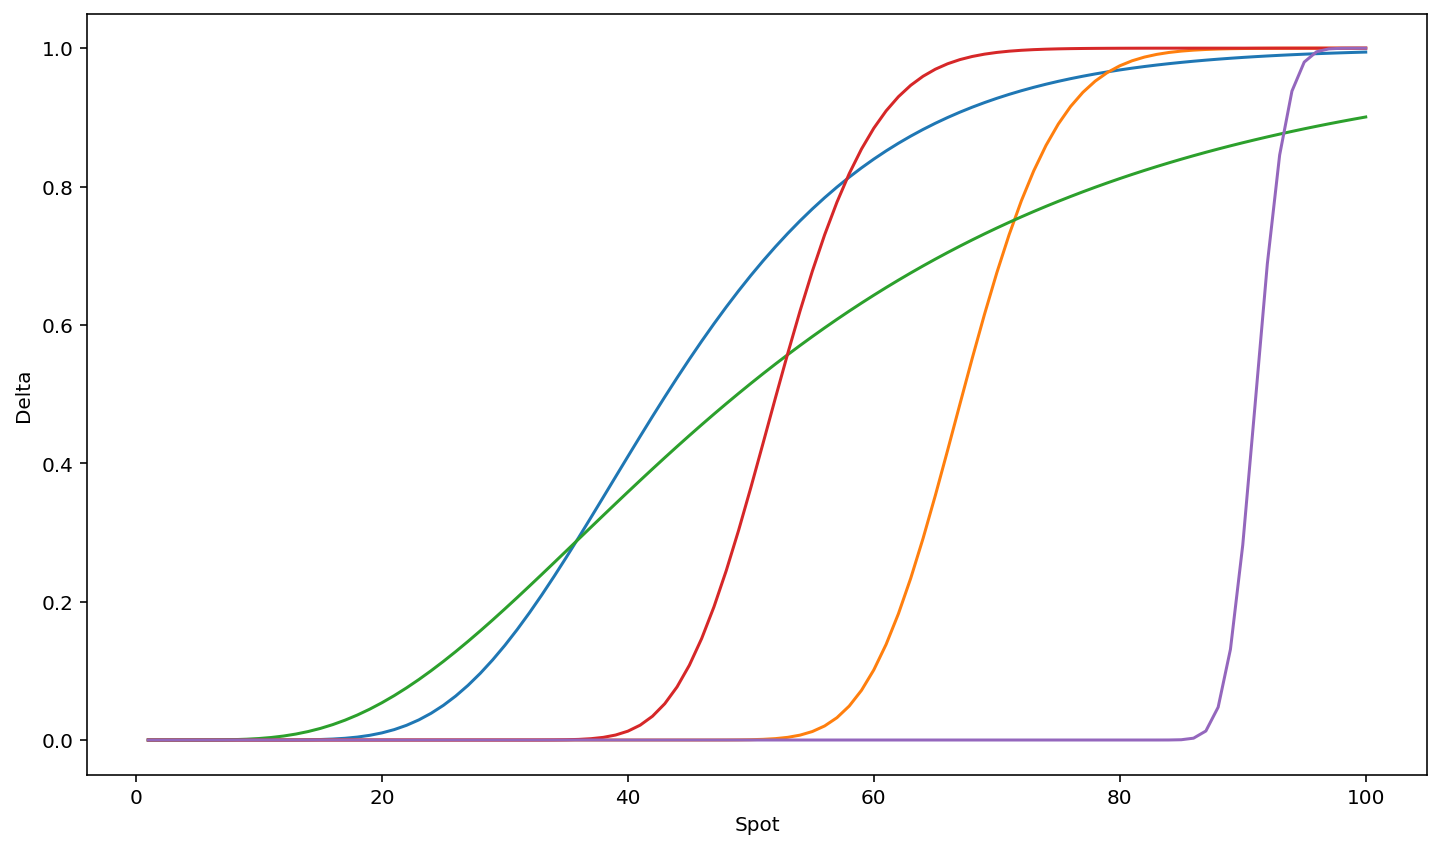

In [12]:
# (i) 

S_upper = 100
graph_num = 5
x = np.linspace(1, S_upper, S_upper)

for j in range(graph_num):
    K = randint(1,100)
    r = random()
    T = random()
    d = random()
    sigma = random()
    y = [Greeks(S, K, r, d, sigma, T).delta() for S in range(1, S_upper+1)]
    plt.plot(x,y)
    plt.xlabel('Spot')
    plt.ylabel('Delta')

From above, we observe that delta of a call option is between $0$ and $1$ because it is a cdf. It is convex at the beginning then it becomes concave.

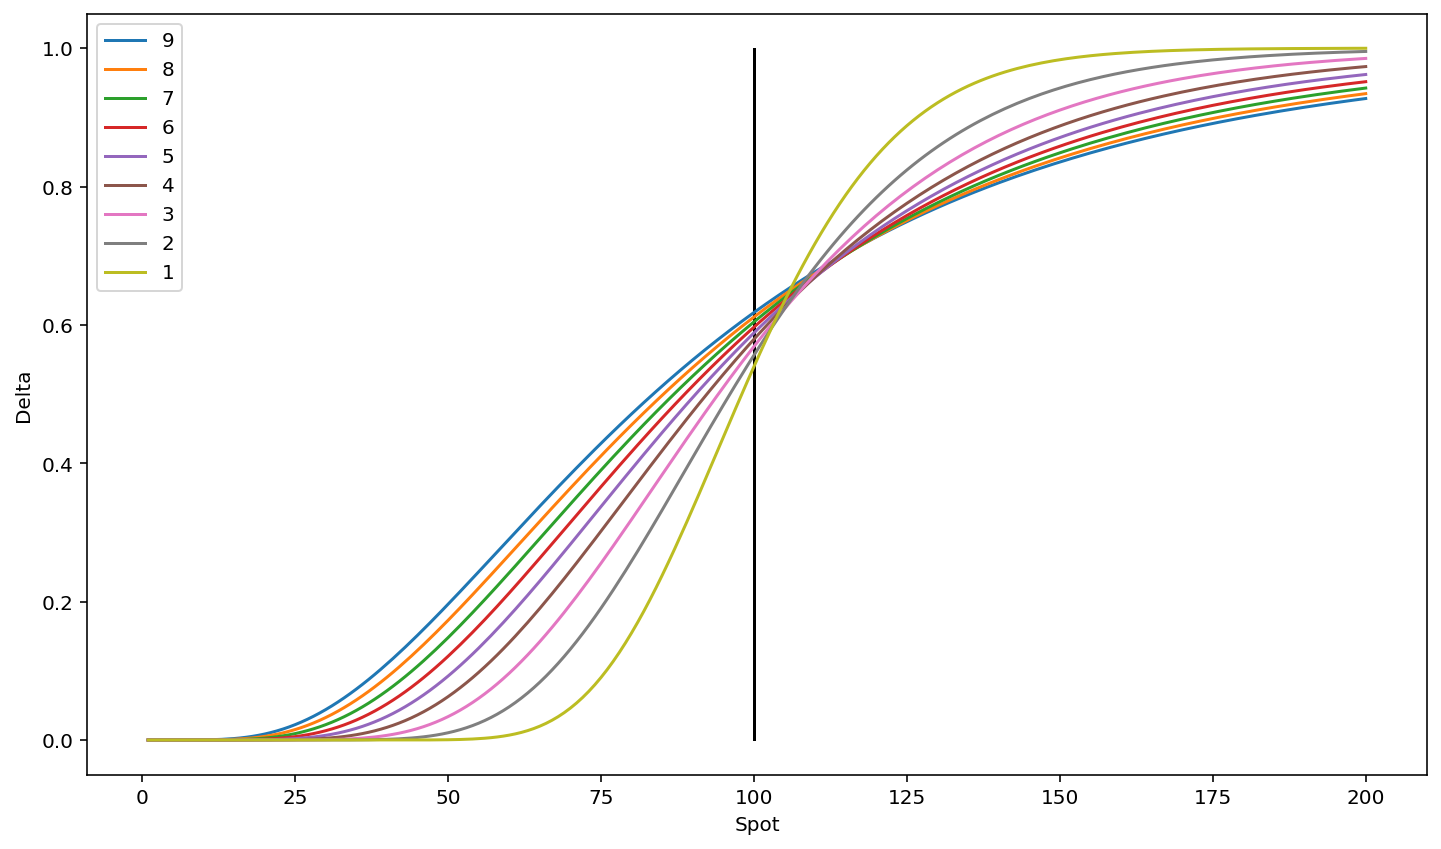

In [13]:
# (ii) 

K = 100
r = 0
d = 0
sigma = 0.2

S_upper = 200
T_upper = 10
x = np.linspace(1, S_upper, S_upper)

for t in reversed(range(1,T_upper)):
    y = [Greeks(S, K, r, d, sigma, t).delta() for S in range(1, S_upper+1)]
    plt.plot(x,y, label = str(t))
    plt.xlabel('Spot')
    plt.ylabel('Delta')
    plt.vlines(K, 0, 1)
    plt.legend()

From above, if time to maturity decreases, then delta of an ITM call option will increase, OTM will decrease and ATM will approach to $0.5$

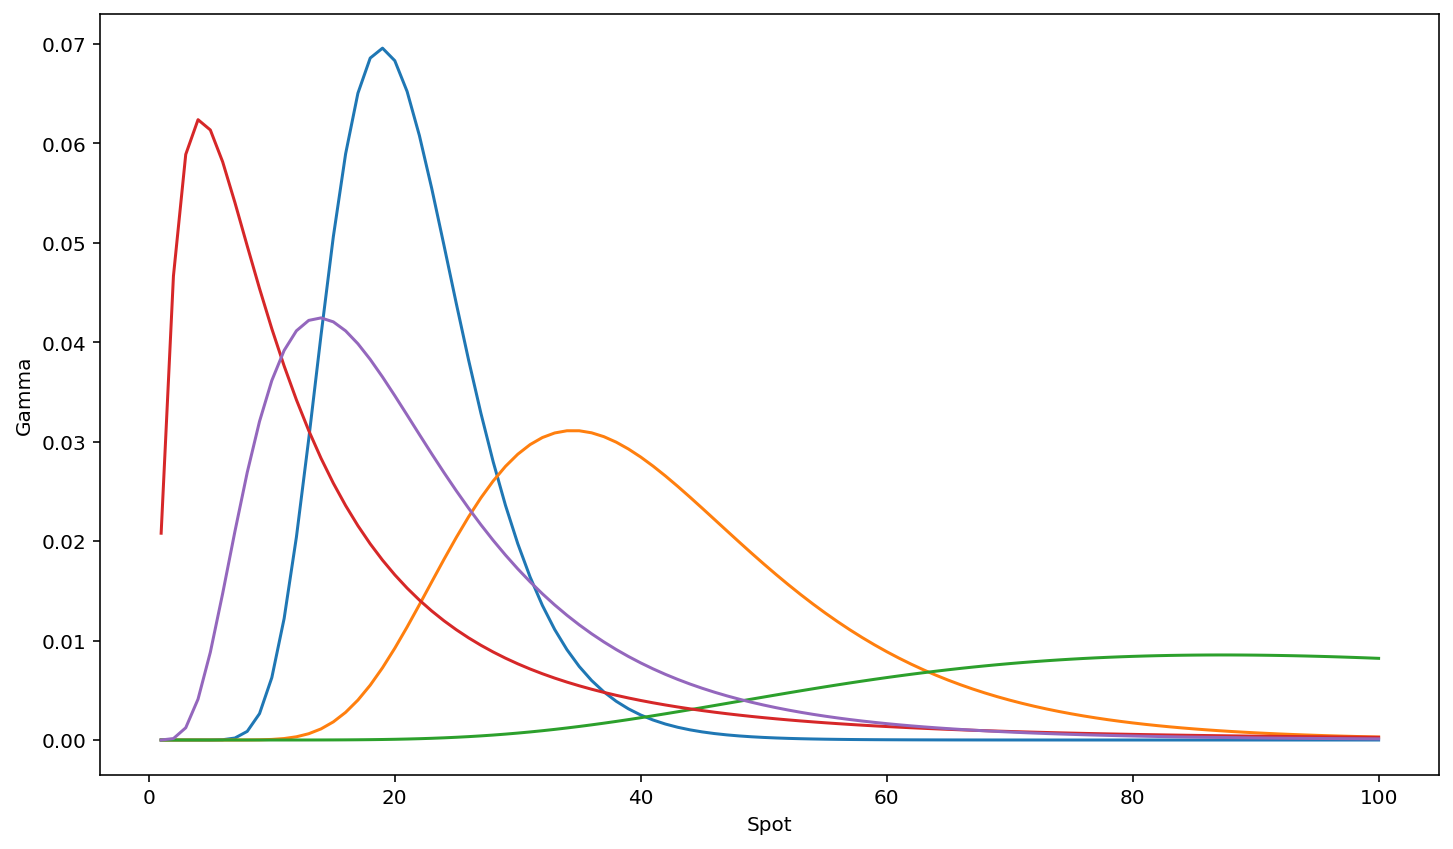

In [14]:
# (iii) 

S_upper = 100
graph_num = 5
x = np.linspace(1, S_upper, S_upper)

for j in range(graph_num):
    K = randint(1,100)
    r = random()
    T = random()
    d = random()
    sigma = random()
    y = [Greeks(S, K, r, d, sigma, T).gamma() for S in range(1, S_upper+1)]
    plt.plot(x,y)
    plt.xlabel('Spot')
    plt.ylabel('Gamma')

From above, gamma of a call option is the normal density function.

(iv) The Vega of a call option as a function of volatility, as a function of spot and as a function of time.

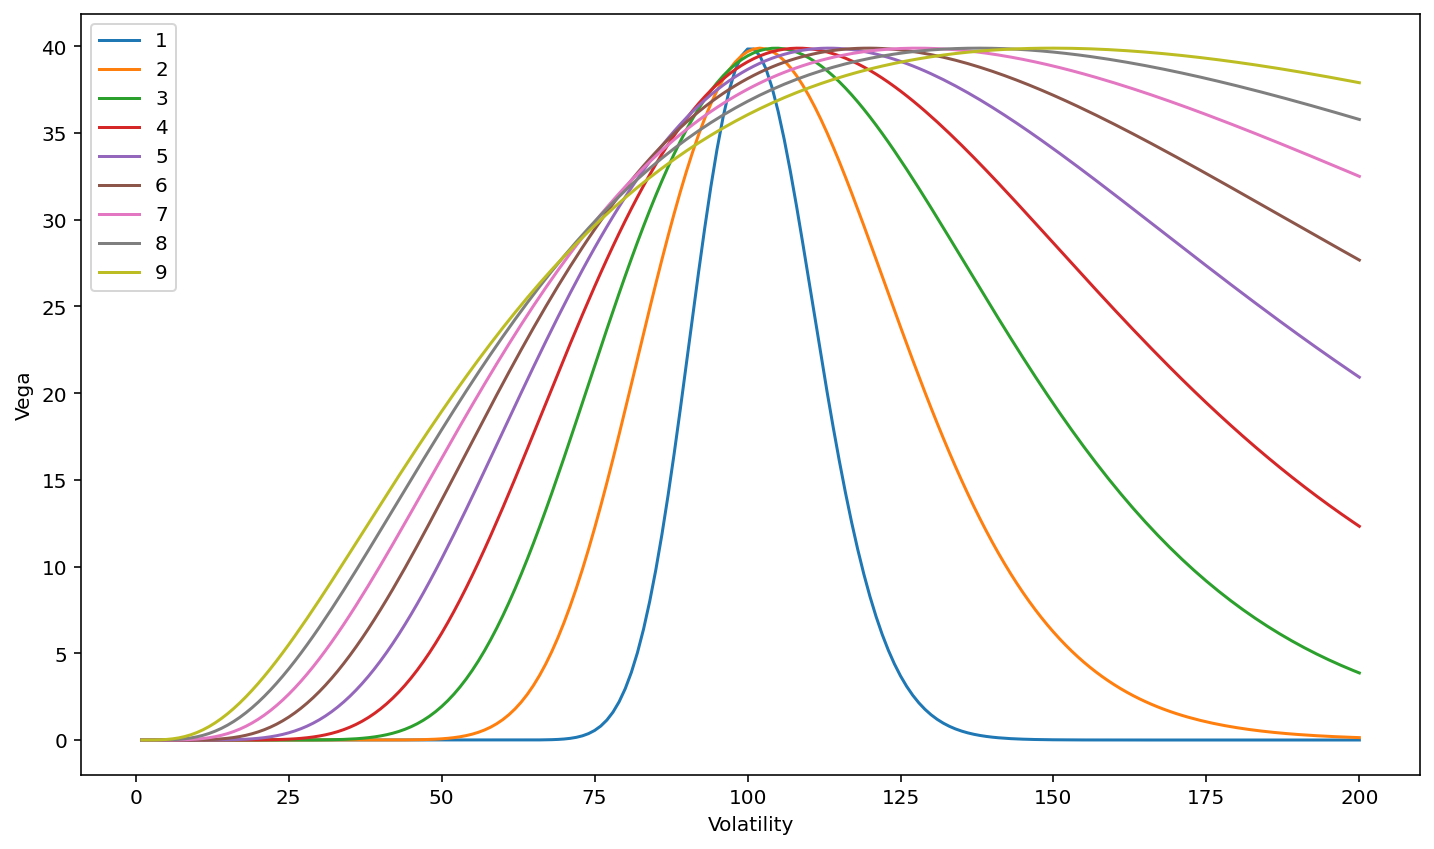

In [15]:
# (iv) function of volatility

K = 100
r = 0
d = 0
T = 1

S_upper = 200
sigma_upper = 10
graph_num = 5
x = np.linspace(1, S_upper, S_upper)

for vol in range(1,sigma_upper):
    y = [Greeks(S, K, r, d, vol / 10, T).vega() for S in range(1, S_upper+1)]
    plt.plot(x,y, label = str(vol))
    plt.xlabel('Volatility')
    plt.ylabel('Vega')
    plt.legend()

Recall that time to maturity and volatility have the same effect to all option Greeks.

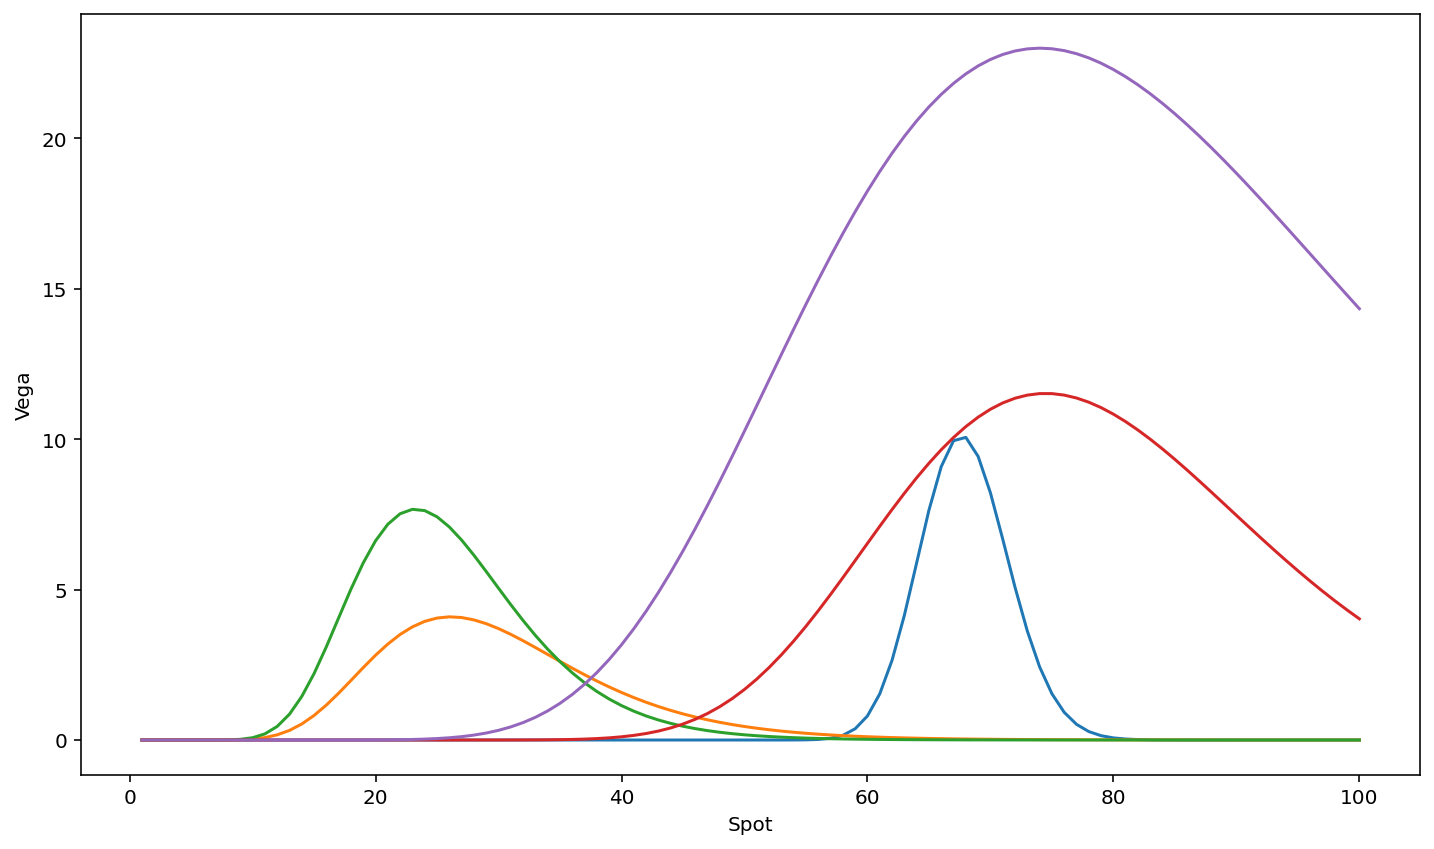

In [16]:
# (iv)   # function of spot

S_upper = 100
graph_num = 5
x = np.linspace(1, S_upper, S_upper)

for j in range(graph_num):
    K = randint(1,100)
    r = random()
    T = random()
    d = random()
    sigma = random()
    y = [Greeks(S, K, r, d, sigma, T).vega() for S in range(1, S_upper+1)]
    plt.plot(x,y)
    plt.xlabel('Spot')
    plt.ylabel('Vega')

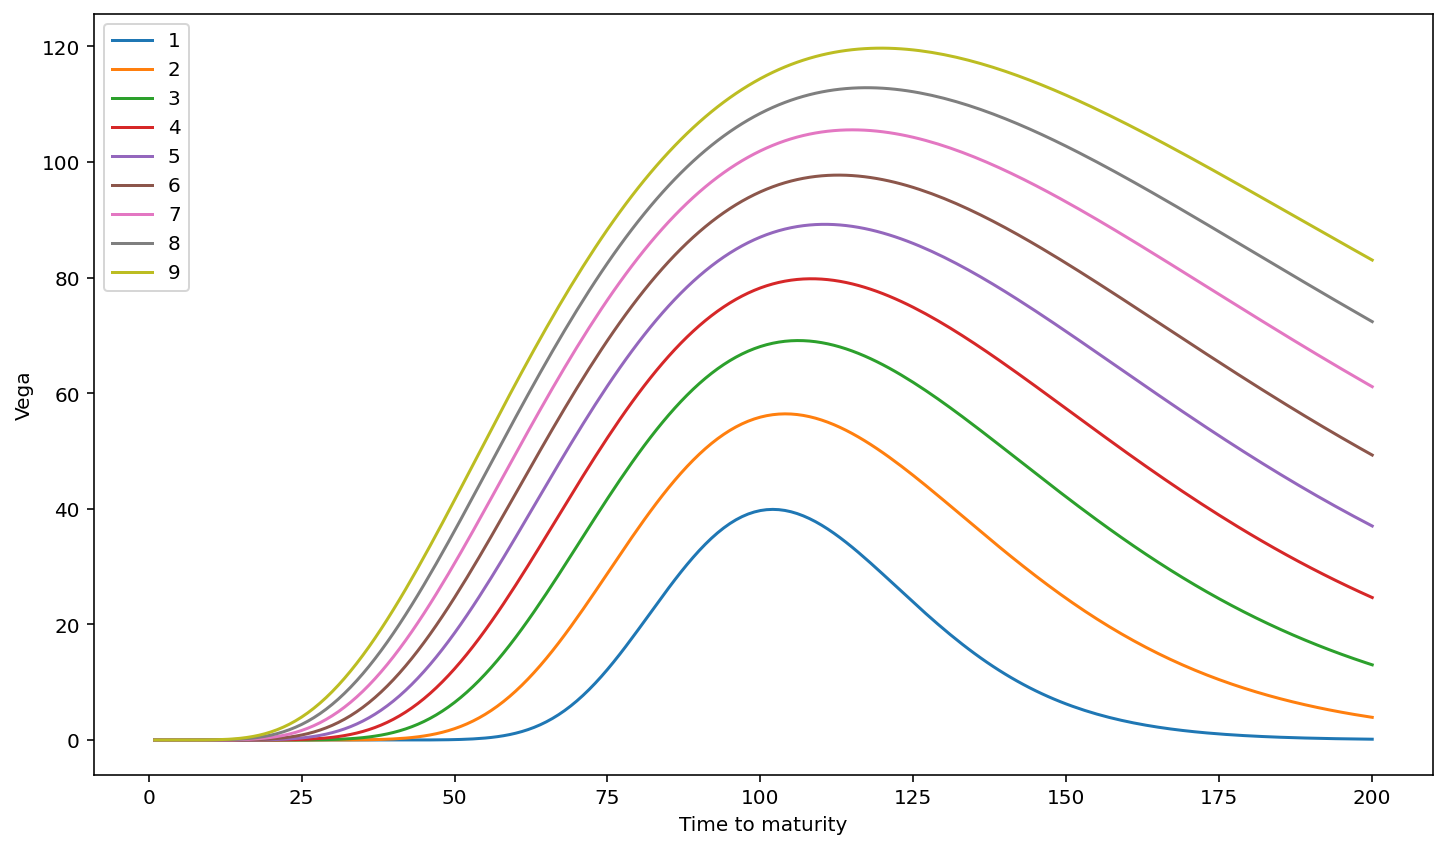

In [17]:
# (iv)  # function of time

K = 100
r = 0
d = 0
sigma = 0.2

S_upper = 200
T_upper = 10
x = np.linspace(1, S_upper, S_upper)

for t in range(1,T_upper):
    y = [Greeks(S, K, r, d, sigma, t).vega() for S in range(1, S_upper+1)]
    plt.plot(x,y, label = str(t))
    plt.xlabel('Time to maturity')
    plt.ylabel('Vega')
    plt.legend()

## Monte Carlo Greeks

We can now try various Monte Carlo methods for computing the Greeks of vanilla options and compare them to the analytical formulas. 
Implement the following methods and compare to the formulas. 
How do the convergence speeds compare?

(i) Run the Monte Carlo twice. 
The second time with the parameter slightly bumped, and finite difference to get the Greek. 
Use different random numbers for the two simulations.

(ii) Do the same again but using the same random numbers for the two simulations.
(Depending upon the language you are using, it will either default to different random numbers or default to the same ones. 
Setting the random number seed is the way to achieve either.)

(iii) Implement the pathwise derivetive estimate method for the Delta.

(iv) Implement the likelihood ratio method for the Delta.

----

For more information on pathwise derivetive estimate and likelihood ratio methods, please refer to the Glasserman's Monte Carlo Methods in Financial Engineering.

Intuitively, the **pathwise derivative estimate method** allows one to calculate greeks by using the ideas of 

(1) **interchanging derivative and integration (expectation)**, if applicable and 

(2) **the Chain rule**.

For example, if we want to calculate delta of an European call option, since $S_T$ is a function of $S_0,$ then pathwise method implies that 
$$\frac{\partial c}{\partial S_0} = \frac{\partial}{\partial S_0} \mathbb{E}[e^{-rT}(S_T-K)^+] = \mathbb{E}\left[ \frac{\partial}{\partial S_0} e^{-rT}(S_T-K)^+ \right] =  \mathbb{E} \left[e^{-rT} 1_{\{S_T>K\}} \frac{\partial S_T}{\partial S_0} \right] =  \mathbb{E} \left[ e^{-rT} 1_{\{S_T>K\}} e^{(r-d - \frac{1}{2} \sigma^2)T + \sigma \sqrt{T} Z} \right] = \mathbb{E} \left[ e^{-rT} 1_{\{S_T>K\}} \frac{S_T}{S_0}\right],$$
where the expectation can be calculated using Monte Carlo method.

The pathwise derivative method can be modified to calculate other greeks as well.

However, one drawback of the pathwise derivative method is that the payoff function must be differentiable or differentiable almost everywhere. 
In the example above, the payoff function $(S_T-K)^+$ is differentiable everywhere except at $S_T = K$. 

The **likelihood ratio method**

In [19]:
# (ii)

e = 0.001


option_type = 'European call'
S0 = 120
K = 100
r = 0.05
d = 0
sigma = 0.2
T = 1

num_steps = 100
num_paths = 17


BS_mc_S = lambda x: black_scholes_monte_carlo_pricer(option_type, S0 + x, K, r, d, sigma, T, num_steps, num_paths, False, 0)
BS_mc_r = lambda x: black_scholes_monte_carlo_pricer(option_type, S0, K, r + x, d, sigma, T, num_steps, num_paths, False, 0)
BS_mc_vol = lambda x: black_scholes_monte_carlo_pricer(option_type, S0, K, r, d, sigma + x, T, num_steps, num_paths, False, 0)
BS_mc_T = lambda x: - black_scholes_monte_carlo_pricer(option_type, S0, K, r, d, sigma, T + x, num_steps, num_paths, False, 0)

delta_mc = finite_difference(BS_mc_S, e)
gamma_mc = finite_difference(BS_mc_S, e, True)
vega_mc = finite_difference(BS_mc_vol, e)
rho_mc = finite_difference(BS_mc_r, e)
theta_mc = finite_difference(BS_mc_T, e)

greeks = Greeks(S0, K, r, d, sigma, T)

print('Delta', delta_mc, greeks.delta())
print('Gamma', gamma_mc, greeks.gamma())
print('Vega', vega_mc, greeks.vega())
print('Rho', rho_mc, greeks.rho())
print('Theta', theta_mc, greeks.theta())

Delta 0.8969911032359335 0.8964550230770805
Gamma 0.002800778275968696 0.007500245963538315
Vega 21.858899215818184 21.600708374990347
Rho 81.34638673126915 81.40555882240236
Theta -6.244217221990311 -6.2303487786191525


Note that the gamma generated using Monte Carlo deviates from true value significantly. This is due to the fact that the european call payoff is not twice differentiable. https://quant.stackexchange.com/questions/18208/greeks-why-does-my-monte-carlo-give-correct-delta-but-incorrect-gamma

In [24]:
# (iii) 

S0 = 120
K = 100
r = 0.05
d = 0
sigma = 0.2
T = 1

num_steps = 100
num_paths = 17

ST = GBM_fd(S0, K, r, d, sigma, T, num_steps, 2**num_paths, plot = False, seed = None)
payoff = np.exp(-r * T) * np.piecewise(ST, [ST > K, ST <= K], [1, 0]) * ST / S0
print('Analytical delta: ', greeks.delta())
print('Pathwise method delta: ' , monte_carlo(payoff))

Analytical delta:  0.8964550230770805
Pathwise method delta:  0.8952245935438147


In [0]:
# (iv)

